# **Importing Necessary Libraries**

In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report


# **Exploring the Dataset**

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!unzip '/content/drive/MyDrive/Suicidal Tweet Dataset.zip' -d '/content/drive/MyDrive/Suicidal Tweet Dataset_unzip'

Archive:  /content/drive/MyDrive/Suicidal Tweet Dataset.zip
  inflating: /content/drive/MyDrive/Suicidal Tweet Dataset_unzip/Suicide_Ideation_Dataset(Twitter-based).csv  


In [36]:
# Sample dataset containing tweets labeled as suicidal or non-suicidal
tweets_data = pd.read_csv('/content/drive/MyDrive/Suicidal Tweet Dataset_unzip/Suicide_Ideation_Dataset(Twitter-based).csv')

In [37]:
tweets_data.head(15)

,Tweet,Suicide
0,making some lunch,Not Suicide post
1,@Alexia You want his money.,Not Suicide post
2,@dizzyhrvy that crap took me forever to put to...,Potential Suicide post
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Not Suicide post
4,Trying out &quot;Delicious Library 2&quot; wit...,Not Suicide post
5,"@ValenValdez Oh, that's good to hear. But is i...",Not Suicide post
6,@mcm180 u've got a list for fellow #hotties? Y...,Not Suicide post
7,@jakepaul @jamescharles @LoganPaul Just becaus...,Potential Suicide post
8,time for some warsaw beer garden chilling,Not Suicide post
9,I hate my life lmao I hope I die soon or sumn ...,Potential Suicide post


In [38]:
import random
index = random.randrange(0, tweets_data.shape[0])
print("Tweet is:\n", tweets_data.iloc[index]['Tweet'])
print("Sentiment is:\n", tweets_data.iloc[index]['Suicide'])

Tweet is:
 gettin off the internet... gonna finish my hair
Sentiment is:
 Not Suicide post


# **Total Tweets in Dataset**

In [39]:
num_tweets = tweets_data.shape[0]
print("Total number of tweets in the dataset: ", num_tweets)

Total number of tweets in the dataset:  1787


# **Total Tweets of each Class**

In [40]:
not_suicide = tweets_data[tweets_data['Suicide']=='Not Suicide post']['Suicide'].count()

In [41]:
potential_suicide = tweets_data[tweets_data['Suicide']=='Potential Suicide post ']['Suicide'].count()

In [42]:
print("Number of not suicide tweets: ", not_suicide)
print("Number of potential suicide tweets: ", potential_suicide)

Number of not suicide tweets:  1127
Number of potential suicide tweets:  660


# **Total Ratio of State of Tweets: Potential Suicide vs Not Suicide**

(1) **BAR GRAPH**

In [43]:
x = ['not suicide post', 'potential suicide post', ]
y = [not_suicide, potential_suicide]

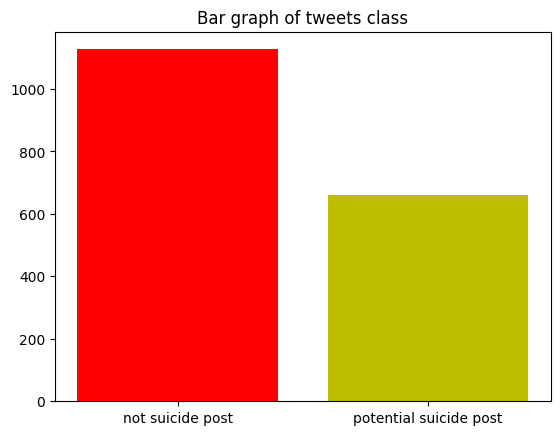

In [44]:
plt.bar(x, y, color=['r', 'y'])
plt.title('Bar graph of tweets class')
plt.show()

(2) **PIE CHART**

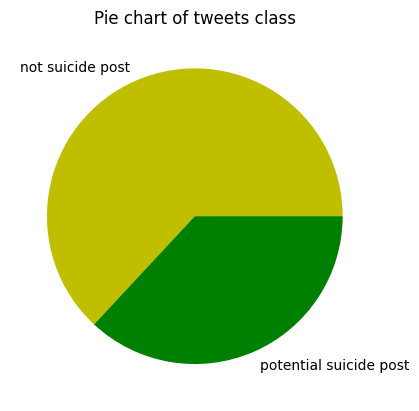

In [45]:
plt.pie(y, labels=x, colors=['y', 'g'])
plt.title("Pie chart of tweets class")
plt.show()

# **One-Hot Encoding**

In [46]:
tweets_data['Suicide'] = tweets_data['Suicide'].replace({'Not Suicide post': 0, 'Potential Suicide post ': 1})

In [47]:
tweets_data.head(15)

,Tweet,Suicide
0,making some lunch,0
1,@Alexia You want his money.,0
2,@dizzyhrvy that crap took me forever to put to...,1
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,0
4,Trying out &quot;Delicious Library 2&quot; wit...,0
5,"@ValenValdez Oh, that's good to hear. But is i...",0
6,@mcm180 u've got a list for fellow #hotties? Y...,0
7,@jakepaul @jamescharles @LoganPaul Just becaus...,1
8,time for some warsaw beer garden chilling,0
9,I hate my life lmao I hope I die soon or sumn ...,1


In [48]:
print("Not Suicide post: ", tweets_data[tweets_data['Suicide']==0]['Suicide'].count())

Not Suicide post:  1127


In [49]:
print("Potential Suicide post:", tweets_data[tweets_data['Suicide']==1]['Suicide'].count())

Potential Suicide post: 660


# **Pre-processing the Text**

In [64]:
# Preprocessing the text
#Conversion of Tweet column of dataframe to list
tweets = tweets_data['Tweet'].astype('str')
tweets = tweets.tolist()
print("Type is: ", type(tweets))

# Conversion of Suicide column of dataframe to list
labels = tweets_data['Suicide'].tolist()
print("Type is: ", type(labels))
# Conversion of Suicide column to array
labels = np.array(labels)

Type is:  <class 'list'>
Type is:  <class 'list'>


In [65]:
# Random tweets from the list
rand_index = random.randrange(0, len(tweets))
print("Tweet is: \n", tweets[rand_index])
if labels[rand_index]==0:
    print("Not Suicide(0)")
else:
    print("Potential Suicide(1)")

Tweet is: 
 I thought Iâve hated myself before but now i really truly hate myself so god damn much.
Potential Suicide(1)


# **Splitting of Dataset into Train & Test**

In [66]:
# Splitting data into training and testing sets
train_tweet, test_tweet, train_label, test_label = train_test_split(tweets, labels, random_state=42, test_size=0.2)

In [67]:
train_tweet[2]

"@margb1509 It's the same here in New Zealand too. Looking forward to them starting again already! Have a great night!"

In [68]:
train_label[2]

0

# ***Pre-processing the Textual Data into Numerical Format ***

**I. Setting up the hyperparameters**

In [69]:
words_count = []
for i in tweets:
    words_count.append(len(i.split()))

In [70]:
max_length = max(words_count) # maximum number of words in a sentence, max length our sequence will be
vocab_size = 1000 # maximum number of unique words in the dataset
pad_type = 'post'
trunc_type = 'pre'
oov_tok = "<OOV>"
embedding_dim = round(np.sqrt(vocab_size))

**II. Tokenization & Padded Sequence on Train & Test Data**

In [71]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_tweet)
word_indexes = tokenizer.word_index

**(a) Train Data**

In [72]:
training_sequences = tokenizer.texts_to_sequences(train_tweet)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                               padding=pad_type, truncating=trunc_type)

**(b) Test Data**

In [73]:
testing_sequences = tokenizer.texts_to_sequences(test_tweet)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                              padding=pad_type, truncating=trunc_type)

# **Applying Deep Learning Model**

In [108]:
# Building the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, 16, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [79]:
# Compilation of a Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [84]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 240, 16)           160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160289 (626.13 KB)
Trainable params: 160289 (626.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [88]:
# Training the model
epochs = 30
history = model.fit(training_padded, train_label, epochs=epochs, validation_data=(testing_padded, test_label), verbose=2)

Epoch 1/30
45/45 - 0s - loss: 0.1125 - accuracy: 0.9685 - val_loss: 0.1759 - val_accuracy: 0.9441 - 466ms/epoch - 10ms/step
Epoch 2/30
45/45 - 0s - loss: 0.1082 - accuracy: 0.9727 - val_loss: 0.1720 - val_accuracy: 0.9413 - 387ms/epoch - 9ms/step
Epoch 3/30
45/45 - 0s - loss: 0.1037 - accuracy: 0.9755 - val_loss: 0.1706 - val_accuracy: 0.9413 - 377ms/epoch - 8ms/step
Epoch 4/30
45/45 - 0s - loss: 0.0998 - accuracy: 0.9727 - val_loss: 0.1727 - val_accuracy: 0.9413 - 471ms/epoch - 10ms/step
Epoch 5/30
45/45 - 0s - loss: 0.0976 - accuracy: 0.9748 - val_loss: 0.1766 - val_accuracy: 0.9358 - 470ms/epoch - 10ms/step
Epoch 6/30
45/45 - 0s - loss: 0.0962 - accuracy: 0.9783 - val_loss: 0.1662 - val_accuracy: 0.9413 - 443ms/epoch - 10ms/step
Epoch 7/30
45/45 - 0s - loss: 0.0906 - accuracy: 0.9755 - val_loss: 0.1637 - val_accuracy: 0.9441 - 442ms/epoch - 10ms/step
Epoch 8/30
45/45 - 0s - loss: 0.0878 - accuracy: 0.9776 - val_loss: 0.1625 - val_accuracy: 0.9441 - 453ms/epoch - 10ms/step
Epoch 9/30

In [89]:
# Evaluate the model
loss, accuracy = model.evaluate(testing_padded, test_label)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

12/12 [==============================] - 0s 3ms/step - loss: 0.1515 - accuracy: 0.9525
Test Loss: 0.1514628827571869
Test Accuracy: 0.9525139927864075


# **Representation of Accuracy & Loss Curve of DL in Graph**

**(a) Accuracy Curve**

In [90]:
def accuracy_plot(model):
    accuracy = model.history['accuracy']
    val_accuracy = model.history['val_accuracy']
    epochs = range(len(history.history['accuracy']))

    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.legend()

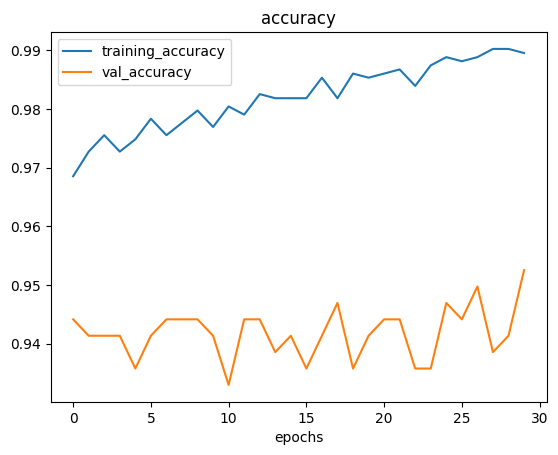

In [91]:
accuracy_plot(history)

**(b) Loss Curve**

In [92]:
def loss_plot(model):
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    epochs = range(len(history.history['loss']))

    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('loss')
    plt.xlabel('epochs')
    plt.legend()

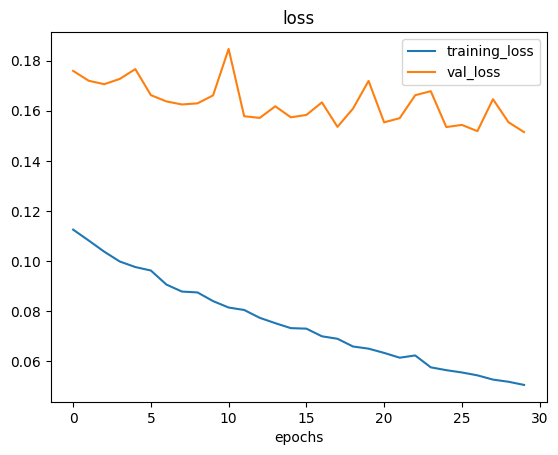

In [93]:
loss_plot(history)

# **Model Prediction on Test Data**

In [99]:
import time
import sys
def load(count=50, filler="=", delay=0.02):
  for i in range(count + 1):
    sys.stdout.write('\r')
    sys.stdout.write("[%s%s]" % (filler * i, ' ' * (count - i)))
    sys.stdout.flush()
    time.sleep(delay)

In [100]:
def userdef_tweet():
    custom_tweet = input("Enter a tweet: ")
    print()
    print("Your tweet is: ", custom_tweet)
    sentence = []
    sentence.append(custom_tweet)
    test_s = tokenizer.texts_to_sequences(sentence)
    test_p = pad_sequences(test_s, maxlen=max_length,
                      padding=pad_type, truncating=trunc_type)
    pred_value = model.predict(test_p)
    print("Predict Value is: ", pred_value)
    load(filler=">")
    print()
    if(pred_value>0.5):
        print("Potential Suicide Tweet")
    else:
        print("Not a suicide Tweet")

In [106]:
userdef_tweet()

Enter a tweet: If you've ever been suicidal or ARE suicidal, I hope this video helps you in any way. You..Are.Not.Alone.

Your tweet is:  If you've ever been suicidal or ARE suicidal, I hope this video helps you in any way. You..Are.Not.Alone.
1/1 [==============================] - 0s 32ms/step
Predict Value is:  [[0.9735394]]
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]
Potential Suicide Tweet


In [102]:
userdef_tweet()

Enter a tweet: Feeling extremely hopeless today, can't bear it anymore

Your tweet is:  Feeling extremely hopeless today, can't bear it anymore
1/1 [==============================] - 0s 33ms/step
Predict Value is:  [[0.0197282]]
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]
Not a suicide Tweet


In [103]:
userdef_tweet()

Enter a tweet: i just wanna die, everything sucks!

Your tweet is:  i just wanna die, everything sucks!
1/1 [==============================] - 0s 23ms/step
Predict Value is:  [[0.9384505]]
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]
Potential Suicide Tweet


In [105]:
userdef_tweet()

Enter a tweet: The weight of emptiness presses down on my chest, making it hard to breathe. #Struggling

Your tweet is:  The weight of emptiness presses down on my chest, making it hard to breathe. #Struggling
1/1 [==============================] - 0s 47ms/step
Predict Value is:  [[0.29191545]]
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]
Not a suicide Tweet


In [104]:
userdef_tweet()

Enter a tweet: A winner is a dreamer who never gives up

Your tweet is:  A winner is a dreamer who never gives up
1/1 [==============================] - 0s 27ms/step
Predict Value is:  [[0.03586114]]
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]
Not a suicide Tweet
